In [2]:
from pathlib import Path

import numpy as np
import torch

from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook, trange

import itertools

import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(), verbose=True)

True

In [3]:
debug = True

# prepare data

In [4]:
from src.utils.ensemble import optimize_val_correlation
from src.config.config import combine_cfgs, get_cfg_defaults
from src.data.datamodule import MyDataModule
from pathlib import Path
import torch
import numpy as np

In [5]:
# prepare train and validation data
cfg = get_cfg_defaults()
cfg.DATASET.TRANSFORM = 'i3d_flow'
cfg.DATASET.FRAMES = 64
dm = MyDataModule(cfg)
dm.prepare_data()
dm.setup()

val_indices = dm.val_dataset.indices
fmris_cache_path = Path('/data/huze/.cache/trainval_fmris.pt')

if fmris_cache_path.exists():
    fmris = torch.load(fmris_cache_path)
else:
    fmris = [dm.dataset_train_val.__getitem__(i)[1]
             for i in tqdm(range(dm.dataset_train_val.__len__()))]
    fmris = np.stack(fmris, 0)
    fmris = torch.tensor(fmris)
    torch.save(fmris, fmris_cache_path)

val_fmris = fmris[val_indices]

In [6]:
mask_img = 'config/reliable_voxel_mask.nii'

In [7]:
voxel_masks = np.load('config/voxel_masks.npy')

In [8]:
noise_ceiling = np.load('config/noise_ceiling.npy')

In [9]:
chaotic_motions = torch.tensor(np.load('./tmp/notebook920/chaotic_motion.npy'))

In [12]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# load models

In [13]:
results_dir = Path('/data/huze/ray_results/algonauts2021')
print('results_dir', results_dir)

results_dir /data/huze/ray_results/algonauts2021


In [14]:
from src.utils.runs import load_run_df

In [15]:
run_df = load_run_df(results_dir)

  0%|          | 0/4218 [00:00<?, ?it/s]

In [16]:
from src.utils.runs import my_query_df, filter_multi_layer_runs, filter_single_layer_runs

In [17]:
run_df.keys()

Index(['DESCRIPTION', 'DATAMODULE.NUM_CV_SPLITS', 'DATAMODULE.I_CV_FOLD',
       'DATASET.NAME', 'DATASET.ROOT_DIR', 'DATASET.TRANSFORM',
       'DATASET.RESOLUTION', 'DATASET.FRAMES', 'DATASET.VOXEL_INDEX_DIR',
       'DATASET.ROI', 'MODEL.BACKBONE.NAME', 'MODEL.BACKBONE.PRETRAINED',
       'MODEL.BACKBONE.PRETRAINED_WEIGHT_DIR', 'MODEL.BACKBONE.DISABLE_BN',
       'MODEL.BACKBONE.LAYERS', 'MODEL.BACKBONE.LAYER_PATHWAYS',
       'MODEL.NECK.NECK_TYPE', 'MODEL.NECK.FIRST_CONV_SIZE',
       'MODEL.NECK.POOLING_MODE', 'MODEL.NECK.SPP_LEVELS',
       'MODEL.NECK.FC_ACTIVATION', 'MODEL.NECK.FC_HIDDEN_DIM',
       'MODEL.NECK.FC_NUM_LAYERS', 'MODEL.NECK.FC_BATCH_NORM',
       'MODEL.NECK.FC_DROPOUT', 'MODEL.NECK.LSTM.HIDDEN_SIZE',
       'MODEL.NECK.LSTM.NUM_LAYERS', 'MODEL.NECK.LSTM.BIDIRECTIONAL',
       'OPTIMIZER.NAME', 'OPTIMIZER.LR', 'OPTIMIZER.WEIGHT_DECAY',
       'SCHEDULER.NAME', 'TRAINER.GPUS', 'TRAINER.FP16', 'TRAINER.MAX_EPOCHS',
       'TRAINER.ACCUMULATE_GRAD_BATCHES', 'TRAIN

In [21]:
baseline_df = filter_multi_layer_runs(run_df)
baseline_df = my_query_df(baseline_df, {'DATASET.ROI': 'WB', 'MODEL.BACKBONE.NAME': '3d_swin'})
baseline_df = baseline_df[baseline_df['TRAINER.CALLBACKS.BACKBONE.DEFROST_SCORE'] == 1.]

In [22]:
predictions_dict = {
    'Baseline': torch.tensor(np.load(baseline_df.path.item().joinpath(Path('prediction.npy')))).float(),
    'Best': torch.load(Path('/data/huze/ray_results/algonauts2021/notebook200/backbone=1,he_sch=H3,intersection_sch=grouped ensemble,subset_roi_sch=WB+aROI+S-htROI-prediction.pt')),
}

all_df = pd.DataFrame(all_df_data)

print(all_df.model_sch.unique())
print(len(all_df))

# compute

In [23]:
# on validation set, but internal variance on the whole set

In [24]:
from src.utils.analysis import get_motion_correlation, get_sequential_internal_variance_motion_correlation

In [25]:
from src.utils.metrics import vectorized_correlation

In [26]:
from src.utils.analysis import upper_tri_masking, my_corrcoef

In [27]:
device = 'cuda:7'

In [28]:
chaotic_motions = chaotic_motions.to(device)
val_fmris = val_fmris.to(device)
fmris = fmris.to(device)
noise_ceiling = torch.tensor(noise_ceiling).float().to(device)

In [29]:
num_fmris = dm.dataset_train_val.__len__()

gt_fmris = fmris
gt_motion_correlation = get_motion_correlation(chaotic_motions[val_indices], gt_fmris[val_indices])
gt_r1 = 1 - upper_tri_masking(my_corrcoef(val_fmris))
gt_motion_correlation_internal_variance = get_sequential_internal_variance_motion_correlation(
    chaotic_motions, gt_fmris).mean()


In [30]:
interest_df = filter_single_layer_runs(
    my_query_df(run_df, 
                equal_dict={
                    'DATASET.ROI': 'WB',
                }))

In [31]:
res_dicts = []
for i_row, row in tqdm(interest_df.iterrows(), total=len(interest_df)):
    path = row.path.joinpath('prediction.npy')
    if path.name.endswith('.pt'):
        prediction = torch.load(path).float()
    else:
        prediction = torch.tensor(np.load(path)).float()

    prediction = prediction.to(device)

    prediction = prediction[:num_fmris]
    motion_correlation = get_motion_correlation(chaotic_motions[val_indices], prediction[val_indices])

    # part 0 - validation score
    val_scores = vectorized_correlation(prediction[val_indices], val_fmris)
    val_scores /= noise_ceiling
    val_score = val_scores.mean().item()

    # part 1 - mc score
    motion_correlation_score = np.corrcoef(motion_correlation, gt_motion_correlation)[0, 1]
    # print(motion_correlation_score)

    # part 2 - mf/fi variance
    motion_correlation_internal_variance = get_sequential_internal_variance_motion_correlation(
        chaotic_motions, prediction).mean()
    # print(motion_correlation_internal_variance)

    # part 3 - rsa score
    r1 = 1 - upper_tri_masking(my_corrcoef(prediction[val_indices]))
    rsa_score = my_corrcoef(torch.stack([r1, gt_r1]))[0, 1].cpu().item()
    # print(rsa_score)

    res_dicts.append({
        'backbone': row['MODEL.BACKBONE.NAME'],
        'val_score': val_score,
        'rsa_score': rsa_score,
        'motion_correlation_internal_variance': motion_correlation_internal_variance,
        'motion_correlation_score': motion_correlation_score,
    })

  0%|          | 0/180 [00:00<?, ?it/s]

In [32]:
for name, prediction in predictions_dict.items():
    prediction = prediction.to(device)

    prediction = prediction[:num_fmris]
    motion_correlation = get_motion_correlation(chaotic_motions[val_indices], prediction[val_indices])

    # part 0 - validation score
    val_scores = vectorized_correlation(prediction[val_indices], val_fmris)
    val_scores /= noise_ceiling
    val_score = val_scores.mean().item()

    # part 1 - mc score
    motion_correlation_score = np.corrcoef(motion_correlation, gt_motion_correlation)[0, 1]
    # print(motion_correlation_score)

    # part 2 - mf/fi variance
    motion_correlation_internal_variance = get_sequential_internal_variance_motion_correlation(
        chaotic_motions, prediction).mean()
    # print(motion_correlation_internal_variance)

    # part 3 - rsa score
    r1 = 1 - upper_tri_masking(my_corrcoef(prediction[val_indices]))
    rsa_score = my_corrcoef(torch.stack([r1, gt_r1]))[0, 1].cpu().item()
    # print(rsa_score)

    res_dicts.append({
        'backbone': name,
        'val_score': val_score,
        'rsa_score': rsa_score,
        'motion_correlation_internal_variance': motion_correlation_internal_variance,
        'motion_correlation_score': motion_correlation_score,
    })

In [33]:
for name, prediction in predictions_dict.items():
    prediction = prediction.to(device)

    prediction = prediction[:num_fmris]
    motion_correlation = get_motion_correlation(chaotic_motions[val_indices], prediction[val_indices])
    
    torch.save(motion_correlation, f'tmp/notebook922/{name}-motion_correlation.pt')

In [34]:
torch.save(gt_motion_correlation, f'tmp/notebook922/gt-motion_correlation.pt')

In [35]:
predictions_dict.keys()

dict_keys(['Baseline', 'Best'])

In [36]:
res_df = pd.DataFrame(res_dicts)

In [37]:
res_df.to_csv('./tmp/notebook922/scatter_res_df.csv')

In [38]:
res_df = pd.read_csv('./tmp/notebook922/scatter_res_df.csv')

In [39]:
res_df

,Unnamed: 0,backbone,val_score,rsa_score,motion_correlation_internal_variance,motion_correlation_score
0,0,2d_pyconvsegnet_warp_3d,0.338922,0.300625,0.095660,0.253060
1,1,2d_pyconvsegnet_warp_3d,0.348198,0.320186,0.094453,0.289070
2,2,2d_pyconvsegnet_warp_3d,0.314212,0.287540,0.094682,0.295808
3,3,2d_pyconvsegnet_warp_3d,0.311066,0.269213,0.097689,0.196223
4,4,2d_pyconvsegnet_warp_3d,0.347521,0.343401,0.091559,0.236123
...,...,...,...,...,...,...
177,177,i3d_flow,0.344656,0.354898,0.091315,0.275696
178,178,i3d_flow,0.296634,0.285281,0.090856,0.254590
179,179,i3d_flow,0.223907,0.235310,0.113258,0.309603
180,180,Baseline,0.372980,0.388438,0.087933,0.347999


In [40]:
num_fmris = dm.dataset_train_val.__len__()

gt_fmris = fmris
gt_motion_correlation = get_motion_correlation(chaotic_motions[val_indices], gt_fmris[val_indices])

gt_motion_correlation_internal_variance = get_sequential_internal_variance_motion_correlation(
    chaotic_motions, gt_fmris).mean()

# nice scatter plot

In [41]:
x_key = 'val_score'
y_keys = ['rsa_score', 'motion_correlation_internal_variance', 'motion_correlation_score']
labels = res_df['backbone'].values

In [42]:
from matplotlib.font_manager import FontProperties
import matplotlib

# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

font = FontProperties()
# font.set_family('serif')
# font.set_name('Times New Roman')
font.set_style('italic')

In [43]:
names = ['Best', 'Baseline', '3d_swin', 'i3d_rgb', '2d_densnet_warp_3d',
       '2d_simclr_warp_3d', '2d_moby_swin_warp_3d',
       '2d_pyconvsegnet_warp_3d', '2d_seg_swin_warp_3d', 'i3d_flow',
       '2d_colorizer_warp_3d', '2d_bdcnvgg_warp_3d', 'audio_vggish']

In [44]:
label_names = ['Best Ensemble', 'Baseline Multi-layer', '3D SwinTransformer-CLS', '3D ResNet-CLS',
       '2D DensNet-CLS', '2D ResNet-SimClr', '2D SwinTransformer-Moby',
       '2D PyConvSegNet-Seg', '2D SwinTransformer-Seg',
       '3D ResNet Flow-CLS', '2D AlexNet-Colorization',
       '2D VGG-EdgeDetection', 'Audio VGGish-CLS']

In [45]:
mapcolors = [[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.73333333, 0.47058824, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.68235294, 0.78039216, 0.90980392, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.78039216, 0.78039216, 0.78039216, 1.        ],
       [0.76862745, 0.61176471, 0.58039216, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.09019608, 0.74509804, 0.81176471, 1.        ],
       [0.59607843, 0.8745098 , 0.54117647, 1.        ],
       [0.96862745, 0.71372549, 0.82352941, 1.        ]]

# for first 2
mapcolors = [mapcolors[0]] + mapcolors

In [46]:
res_df

,Unnamed: 0,backbone,val_score,rsa_score,motion_correlation_internal_variance,motion_correlation_score
0,0,2d_pyconvsegnet_warp_3d,0.338922,0.300625,0.095660,0.253060
1,1,2d_pyconvsegnet_warp_3d,0.348198,0.320186,0.094453,0.289070
2,2,2d_pyconvsegnet_warp_3d,0.314212,0.287540,0.094682,0.295808
3,3,2d_pyconvsegnet_warp_3d,0.311066,0.269213,0.097689,0.196223
4,4,2d_pyconvsegnet_warp_3d,0.347521,0.343401,0.091559,0.236123
...,...,...,...,...,...,...
177,177,i3d_flow,0.344656,0.354898,0.091315,0.275696
178,178,i3d_flow,0.296634,0.285281,0.090856,0.254590
179,179,i3d_flow,0.223907,0.235310,0.113258,0.309603
180,180,Baseline,0.372980,0.388438,0.087933,0.347999


In [53]:
plt.style.use('default')

In [54]:
import scipy

-0.20208076698578556 0.00622444014426316


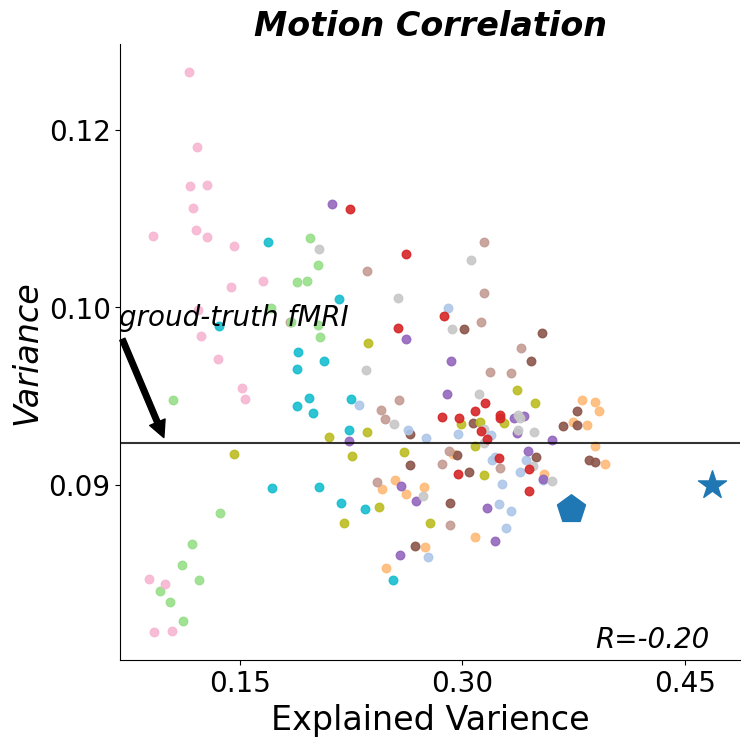

0.6757087332041009 1.268195599439699e-25


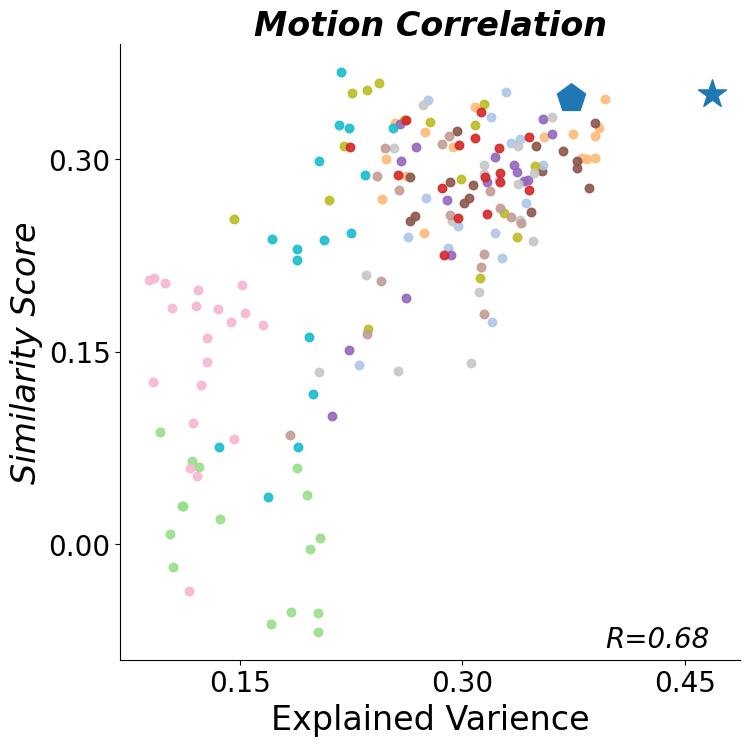

0.9627359525029542 3.6616477319090354e-104


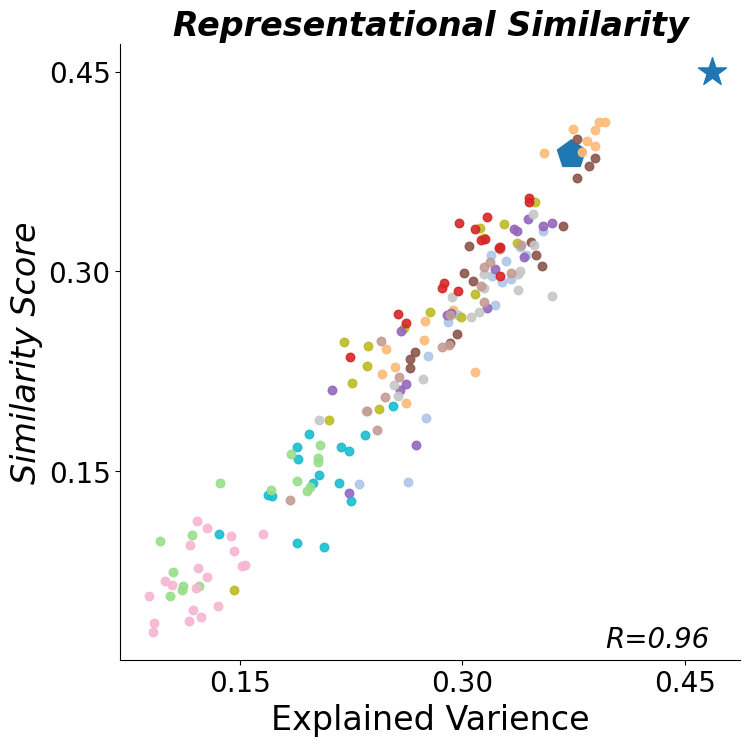

In [57]:
for y_key in sorted(y_keys):

    fig, ax = plt.subplots(figsize=(8, 8))

    all_xs = []
    all_ys = []
    for i, name in enumerate(names):

        if name == 'Best':
            size = 450
            marker = '*'
            alpha = 1.
        elif name == 'Baseline':
            size = 450
            marker = 'p'
            alpha = 1.
        else:
            size = 150
            marker = '.'
            alpha = .9

        i_df = res_df[res_df['backbone'] == name]
        xs = i_df['val_score']
        ys = i_df[y_key]
        ax.scatter(xs, ys, color=mapcolors[i], label=label_names[i],
                  s=size, marker=marker, alpha=alpha)

        for i in xs:
            all_xs.append(i)
        for i in ys:
            all_ys.append(i)
            
    if y_key == 'motion_correlation_internal_variance':
        ax.axhline(y=gt_motion_correlation_internal_variance, color='black', linestyle='-', alpha=.8)
        ax.annotate('groud-truth fMRI', xy=(0.1, gt_motion_correlation_internal_variance), xytext=(0.068, gt_motion_correlation_internal_variance+0.01),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20, fontproperties=font)
    
    plt.xlabel('Explained Varience')
    ylabel = y_key.replace('_', ' ')
    if 'score' in ylabel:
        ylabel = 'Similarity Score'
    if 'internal variance' in ylabel:
        ylabel = 'Variance'    
    plt.ylabel(ylabel, fontdict={'style': 'italic'})
    title = y_key.replace('_', ' ').replace(' score', '').replace(' internal variance', '')
    title = title.replace('rsa', 'Representational Similarity').replace('motion correlation', 'Motion Correlation')
    plt.title(title, fontsize=24, fontweight='bold', fontproperties=font)

    formatter = matplotlib.ticker.FormatStrFormatter('%1.2f')
    locator = matplotlib.ticker.MaxNLocator(nbins=4)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    formatter = matplotlib.ticker.FormatStrFormatter('%1.2f')
    locator = matplotlib.ticker.MaxNLocator(nbins=4)
    ax.yaxis.set_major_locator(locator)
    ax.yaxis.set_major_formatter(formatter)

    r, p = scipy.stats.pearsonr(all_xs, all_ys)
    print(r, p)
    ax.text(0.95, 0.01, f'R={r:.2f}',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=20, fontproperties=font)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)

    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

    # plt.legend(loc='upper left', bbox_to_anchor=(1., 1.), ncol=1, prop={'size': 16, 'weight': 'normal'})

    plt.savefig(f'tmp/notebook922/{y_key}.pdf', bbox_inches="tight")

    plt.show()

In [61]:
np.max(all_xs)

0.468584269285202

In [ ]:
xs = res_df[x_key].values
for y_key in sorted(y_keys):
    ys = res_df[y_key].values
    
    # for x, y, label in zip(xs, ys, labels):
    #     plt.scatter(x, y, label=label)
    # plt.legend()
    # plt.show()
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.scatterplot(x=x_key, y=y_key, 
                    hue='backbone', 
                    style='backbone',
                    size=res_df['size'].values.tolist(),
                    sizes=(100, 500),
                    # palette=['deepskyblue', 'deeppink', 'green', 'deeppink', 'green', 'darkblue', 'darkgreen', 'darkred', 'black'],
                    # markers=['o', 's', 's', 'o', 'o', '^', '^', '^', 'X'],
                    legend='full',
                    alpha=res_df['alpha'].values.tolist(),
                    data=res_df)
    
    if y_key == 'motion_correlation_internal_variance':
        ax.axhline(y=gt_motion_correlation_internal_variance, color='black', linestyle='-', alpha=.8)
        ax.annotate('groud-truth fMRI', xy=(0.1, gt_motion_correlation_internal_variance), xytext=(0.068, gt_motion_correlation_internal_variance-0.01),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20, fontproperties=font)
    
    # title, xy label
    plt.xlabel('validation score', fontsize=24)
    ylabel = y_key.replace('_', ' ')
    if 'score' in ylabel:
        ylabel = 'correlation score'
    if 'internal variance' in ylabel:
        ylabel = 'variance'
    plt.ylabel(ylabel, fontsize=24, fontproperties=font, fontweight='normal')
    title = y_key.replace('_', ' ').replace(' score', '').replace(' internal variance', '')
    title = title.replace('rsa', 'RSA')
    plt.title(title, fontsize=24, fontweight='bold', fontproperties=font)
    
    formatter = matplotlib.ticker.FormatStrFormatter('%1.2f')
    locator = matplotlib.ticker.MaxNLocator(nbins=4)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    formatter = matplotlib.ticker.FormatStrFormatter('%1.2f')
    locator = matplotlib.ticker.MaxNLocator(nbins=4)
    ax.yaxis.set_major_locator(locator)
    ax.yaxis.set_major_formatter(formatter)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    r = np.corrcoef(res_df[x_key], res_df[y_key])[0, 1]
    ax.text(0.95, 0.01, f'R={r:.2f}',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=20, fontproperties=font)
    
#     for i, (color, model_schs) in enumerate(r_palette_group.items()):
#         df = res_df
#         # df['model_sch'] = df['model_sch'].apply(lambda x: [x])
#         df = df[df['model_sch'].isin(model_schs)]
#         r = np.corrcoef(df.val_score, df[y_key])[0, 1]
#         ax.text(0.95, 0.01+(i+1)*0.05, f'R={r:.2f}',
#         verticalalignment='bottom', horizontalalignment='right',
#         transform=ax.transAxes,
#         color=color, fontsize=20, fontproperties=font)
    
#     legend = ax.legend()
#     # order = [0, 1, 2, 3, 4, 5, 7, 6, 8]
#     legend_cols = 1
#     # new_handels = np.asarray(legend.legendHandles[:-3])
#     legend = ax.legend(*list(zip(*list(zip(*ax.get_legend_handles_labels()))[:-3])), 
#                       bbox_to_anchor=(1.5,0.5), loc="center", 
#                         bbox_transform=fig.transFigure, ncol=legend_cols,
#                       fontsize=18,
#                       frameon=False)
#     for handle in legend.legendHandles:
#         handle.set_sizes([200.0])
    
#     # for handle in legend.legendHandles[-3:]:
#     #     handle.set_sizes([0.0])
    
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     # plt.show()
#     # fig.savefig('test.png', bbox_extra_artists=[legend], bbox_inches='tight')
#     ax.get_legend().remove()
#     fig.savefig(f'figures/SCATTER {y_key}.pdf', bbox_inches='tight')
    
    
    # https://gist.github.com/rldotai/012dbb3294bb2599ff82e61e82356990
    
    # ---------------------------------------------------------------------
    # Create a separate figure for the legend
    # ---------------------------------------------------------------------
    # Bounding box for legend (in order to get proportions right)
    # Issuing a draw command seems necessary in order to ensure the layout
    # happens correctly; I was getting weird bounding boxes without it.
#     fig.canvas.draw()
#     # This gives pixel coordinates for the legend bbox (although perhaps 
#     # if you are using a different renderer you might get something else).
#     legend_bbox = legend.get_tightbbox(fig.canvas.get_renderer())
#     # Convert pixel coordinates to inches
#     legend_bbox = legend_bbox.transformed(fig.dpi_scale_trans.inverted())

#     # Create teh separate figure, with appropriate width and height
#     # Create a separate figure for the legend
#     legend_fig, legend_ax = plt.subplots(figsize=(legend_bbox.width, legend_bbox.height))

#     # Recreate the legend on the separate figure/axis
#     legend_squared = legend_ax.legend(
#         *list(zip(*list(zip(*ax.get_legend_handles_labels()))[:-3])), 
#         # bbox_to_anchor=(0., 0., .1, .1),
#         bbox_transform=legend_fig.transFigure,
#         frameon=False,
#         fancybox=None,
#         shadow=False,
#         ncol=legend_cols,
#         mode='expand',
#     )

    # # Remove everything else from the legend's figure
    # legend_ax.axis('off')
    # # plt.margins(x=0, y=0)
    # # bbox = legend_ax.get_tightbbox(legend_fig.canvas.get_renderer(), 
    # #                  call_axes_locator = True,
    # #                  bbox_extra_artists = None)
    # # Save the legend as a separate figure
    # legend_figpath = 'figures/SCATTER legend.pdf'
    # # print(f"Saving to: {legend_figpath}")
    # legend_fig.savefig(
    #     legend_figpath,
    #     bbox_inches='tight',
    #     # bbox_extra_artists=[legend_squared],
    # )
    plt.legend(loc='upper left', bbox_to_anchor=(0., -0.2), ncol=4, prop={'size': 16, 'weight': 'normal'})

    plt.show()
    # break